In [60]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.inspection import permutation_importance
import shap
from matplotlib import pyplot as plt

In [61]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
sns.set_style('whitegrid')
from os import listdir
from os.path import isfile, join
from pandas_datareader import data
import yfinance as yf
import math
import pmdarima as pm

In [62]:
AAPL_df = pd.read_csv('../AAPL_Data.csv', index_col = [0])
AAPL_cols = AAPL_df.columns.tolist()
AAPL_cols.remove('Close')
AAPL_cols = ['Close'] + AAPL_cols
AAPL_df = AAPL_df[AAPL_cols]
# AAPL_df = AAPL_df[['Date', 'Close']]
AAPL_df

,Close,Date,Volume,Adj Close,^DJI_Close,^IXIC_Close,^GSPC_Close,^RLG_Close,^NYA_Close,^VIX_Close,...,TMO_Close,MSFT_Close,DHR_Close,TSLA_Close,LOW_Close,NEE_Close,AVGO_Close,LIN_Close,COST_Close,ACN_Close
0,27.332500,2015-01-02,212818400,24.565697,17832.990234,4726.810059,2058.199951,960.280029,10830.919922,17.790001,...,128.119995,46.759998,64.988625,14.620667,67.699997,26.672501,100.089996,129.949997,141.610001,88.839996
1,26.562500,2015-01-05,257142000,23.873644,17501.650391,4652.569824,2020.579956,943.780029,10607.679688,19.920000,...,126.360001,46.330002,64.344200,14.006000,66.080002,26.389999,98.489998,126.519997,140.000000,87.339996
2,26.565001,2015-01-06,263188400,23.875887,17371.640625,4592.740234,2002.609985,935.020020,10514.870117,21.120001,...,125.180000,45.650002,63.904472,14.085333,66.230003,26.492500,96.250000,124.900002,141.850006,86.709999
3,26.937500,2015-01-07,160423600,24.210682,17584.519531,4650.470215,2025.900024,946.880005,10627.129883,19.309999,...,128.929993,46.230000,64.291130,14.063333,68.199997,26.735001,98.849998,126.300003,144.320007,88.529999
4,27.972500,2015-01-08,237458000,25.140909,17907.869141,4736.189941,2062.139893,964.159973,10800.540039,17.010000,...,130.270004,47.590000,65.284309,14.041333,69.639999,26.897499,103.790001,128.380005,145.559998,89.879997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002,131.860001,2022-12-23,63814900,131.658981,33203.929688,10497.860352,3844.820068,2165.620117,15188.450195,20.870001,...,540.679993,238.729996,259.859985,123.150002,201.880005,84.169998,552.429993,329.329987,462.649994,266.089996
2003,130.029999,2022-12-27,69007800,129.831772,33241.558594,10353.230469,3829.250000,2144.899902,15218.259766,21.650000,...,545.440002,236.960007,260.880005,109.099998,201.710007,84.000000,553.539978,328.950012,458.500000,265.309998
2004,126.040001,2022-12-28,85438400,125.847855,32875.710938,10213.290039,3783.219971,2117.199951,15037.320312,22.139999,...,543.409973,234.529999,259.339996,112.709999,200.059998,83.160004,544.890015,325.910004,452.989990,263.119995
2005,129.610001,2022-12-29,75703700,129.412415,33220.800781,10478.089844,3849.280029,2163.790039,15241.209961,21.440001,...,557.010010,241.009995,266.850006,121.820000,202.259995,84.080002,557.809998,329.750000,456.529999,268.380005


In [63]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler


def data_normalisation(df):
    scaler=MinMaxScaler(feature_range=(0,1))
#     scaler= StandardScaler()
    for column_name in list(df.columns.values):
        if column_name == 'Date':
            continue
        the_list = df[column_name].tolist()
        the_list = np.array(the_list)
        the_list = scaler.fit_transform(the_list.reshape(-1,1))
        df.drop(column_name, axis = 1, inplace = True)
        df[column_name] = the_list
    return df
        
def split_train_test_data(df, lookback,num_feature=1):
    df_list = df.loc[:, df.columns != 'Date'].values.tolist()
    res_list = df['Close'].tolist()
    res_list = np.array(res_list)
#     print(len(res_list))
    data = []
    res_data = []

    for index in range(len(df_list) - lookback -1): 
        the_list = df_list[index: index + lookback]
        the_list= np.array(the_list)
        the_list = the_list.reshape(-1)
#         print(the_list.shape)
        if index==0:
            print(the_list)
        data.append(the_list)
        res_data.append(res_list[index + lookback:index + lookback + 1])

    data = np.array(data)
    res_data = np.array(res_data)
    
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)*2
    
    x_train = data[:train_set_size]
    y_train = res_data[:train_set_size]
    y_train = np.squeeze(y_train)
    
    x_val = data[train_set_size:train_set_size+test_set_size]
    y_val = res_data[train_set_size:train_set_size+test_set_size]
    y_val = np.squeeze(y_val)
    
    x_test = data[train_set_size+test_set_size:]
    y_test = res_data[train_set_size+test_set_size:]
    y_test = np.squeeze(y_test)
    
    return [x_train, y_train,x_val,y_val, x_test, y_test]

In [64]:
lookback = 1 # choose sequence length
normalised_AAPL_df = data_normalisation(AAPL_df)
x_train, y_train,x_val,y_val, x_test, y_test = split_train_test_data(normalised_AAPL_df, lookback,num_feature=1)# change the num_feature value for using more features
# x_test = np.squeeze(x_test)
print(x_train[0])

[0.0297789  0.28946222 0.02304532 0.10278454 0.0390116  0.07721029
 0.03296827 0.23944136 0.11760707 0.09757073 0.85565484 0.94078641
 0.13510538 0.2264055  0.55984628 0.         0.         0.
 0.         0.08963356 0.42032773 0.04252972 0.89438758 0.93579767
 0.         0.91113392 0.69756554 0.74834983 0.62611012 0.28115016
 0.16460905 0.10813433 0.         0.         0.12121212 0.91089716
 0.         0.50058757 0.         0.01819307 0.02136582 0.0107685
 0.01259433 0.02171934 0.04328958 0.00664325 0.13511786 0.01872343
 0.01451461]
[0.0297789  0.28946222 0.02304532 0.10278454 0.0390116  0.07721029
 0.03296827 0.23944136 0.11760707 0.09757073 0.85565484 0.94078641
 0.13510538 0.2264055  0.55984628 0.         0.         0.
 0.         0.08963356 0.42032773 0.04252972 0.89438758 0.93579767
 0.         0.91113392 0.69756554 0.74834983 0.62611012 0.28115016
 0.16460905 0.10813433 0.         0.         0.12121212 0.91089716
 0.         0.50058757 0.         0.01819307 0.02136582 0.0107685


In [65]:
rf = RandomForestRegressor(n_estimators=100, criterion='squared_error')
rf.fit(x_train, y_train)
predictions = rf.predict(x_test)
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.58 degrees.


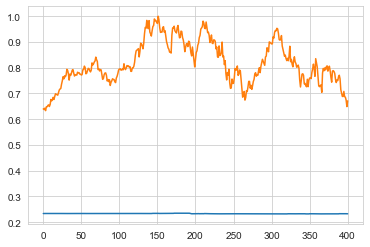

In [66]:
x=[i for i in range(len(x_test))]
plt.plot(x, predictions)
plt.plot(x, y_test)
# plt.imshow()

In [67]:
scaler=MinMaxScaler()
rf_feature = rf.feature_importances_
rf_feature = scaler.fit_transform(rf_feature.reshape(-1, 1))
rf_feature

array([[1.00000000e+00],
       [2.97956757e-04],
       [7.17654414e-01],
       [6.90916291e-04],
       [4.27757445e-04],
       [2.15133276e-03],
       [3.01063057e-03],
       [5.24174072e-04],
       [1.83557085e-04],
       [1.64552312e-04],
       [3.41779827e-04],
       [1.87682764e-04],
       [2.42907608e-04],
       [2.44776582e-04],
       [2.15115959e-04],
       [2.77032218e-04],
       [4.12323663e-04],
       [6.90006951e-05],
       [1.77797214e-04],
       [3.46658482e-05],
       [2.31602023e-04],
       [2.34521340e-05],
       [7.35105496e-06],
       [4.92677491e-05],
       [0.00000000e+00],
       [8.26010310e-06],
       [4.11875239e-05],
       [3.30416590e-05],
       [1.48802371e-05],
       [2.76567524e-05],
       [1.32271174e-04],
       [1.04214460e-05],
       [9.21892121e-07],
       [3.14006143e-06],
       [5.16024247e-06],
       [3.81044538e-05],
       [2.34097740e-05],
       [2.52885674e-04],
       [2.94424192e-03],
       [1.60274365e-04],


In [68]:
reg = GradientBoostingRegressor()
reg.fit(x_train, y_train)
predictions = reg.predict(x_test)
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.59 degrees.


In [69]:
xg_feature = reg.feature_importances_
xg_feature = scaler.fit_transform(xg_feature.reshape(-1, 1))
xg_feature

array([[8.14876574e-01],
       [8.45350195e-05],
       [1.00000000e+00],
       [3.13460405e-05],
       [1.49077693e-04],
       [2.15075226e-03],
       [2.86072250e-05],
       [1.51654181e-02],
       [1.04606405e-04],
       [5.97831132e-05],
       [1.08673482e-04],
       [1.56066935e-04],
       [1.57501097e-04],
       [1.03613313e-04],
       [6.29691162e-05],
       [1.61478538e-04],
       [3.79141303e-05],
       [1.89722159e-05],
       [2.45305051e-04],
       [1.01053904e-04],
       [0.00000000e+00],
       [2.01351325e-05],
       [1.97155105e-05],
       [1.24261109e-04],
       [0.00000000e+00],
       [1.44133855e-05],
       [1.24819276e-06],
       [4.44680321e-07],
       [4.37180545e-08],
       [4.65885849e-04],
       [1.98657232e-04],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [1.17650677e-04],
       [1.14853352e-05],
       [1.02226649e-04],
       [8.87332081e-03],
       [4.85162426e-05],


In [70]:
reg = DecisionTreeRegressor(max_depth=1000)
reg.fit(x_train, y_train)
predictions = reg.predict(x_test)
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.59 degrees.


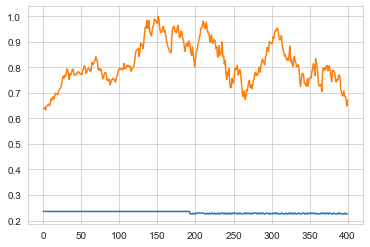

In [71]:
plt.plot(x, predictions)
plt.plot(x, y_test)

In [72]:
reg = RidgeCV()
reg.fit(x_train, y_train)
predictions = reg.predict(x_test)
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.09 degrees.


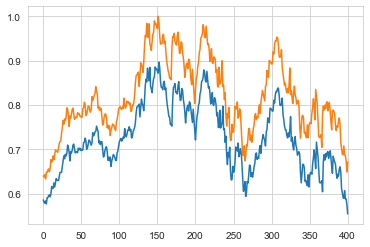

In [73]:
x=[i for i in range(len(x_test))]
plt.plot(x, predictions)
plt.plot(x, y_test)

In [74]:
RidgeCV_feature = reg.coef_
RidgeCV_feature = scaler.fit_transform(RidgeCV_feature.reshape(-1, 1))
RidgeCV_feature

array([[1.        ],
       [0.13456762],
       [0.95654992],
       [0.11623587],
       [0.2682778 ],
       [0.2022348 ],
       [0.26459053],
       [0.13810658],
       [0.15269679],
       [0.1232141 ],
       [0.11620716],
       [0.13632523],
       [0.1568078 ],
       [0.071201  ],
       [0.16157534],
       [0.15513122],
       [0.17418478],
       [0.15053419],
       [0.08211748],
       [0.11273032],
       [0.12144425],
       [0.11335008],
       [0.09847171],
       [0.10568826],
       [0.08840942],
       [0.15661532],
       [0.13649478],
       [0.12911648],
       [0.16348576],
       [0.17256345],
       [0.15299729],
       [0.16064639],
       [0.13631659],
       [0.03771258],
       [0.12211482],
       [0.15351558],
       [0.13468082],
       [0.13868446],
       [0.11421027],
       [0.12984115],
       [0.18949145],
       [0.        ],
       [0.12480497],
       [0.12030089],
       [0.26040986],
       [0.16786741],
       [0.10441979],
       [0.273

In [75]:
reg = LinearRegression()
reg.fit(x_train, y_train)
predictions = reg.predict(x_test)
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.19 degrees.


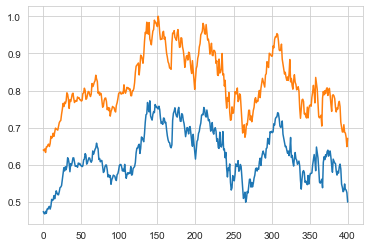

In [76]:
plt.plot(x, predictions)
plt.plot(x, y_test)

In [77]:
LR_feature = reg.coef_
LR_feature = scaler.fit_transform(LR_feature.reshape(-1, 1))
LR_feature

array([[1.        ],
       [0.18435733],
       [0.1273802 ],
       [0.15978679],
       [0.12803638],
       [0.        ],
       [0.35998517],
       [0.26550589],
       [0.19066091],
       [0.18403509],
       [0.18146376],
       [0.18765214],
       [0.19547189],
       [0.17136652],
       [0.1740596 ],
       [0.1882998 ],
       [0.1797263 ],
       [0.16073387],
       [0.25075852],
       [0.17301981],
       [0.33167519],
       [0.15190331],
       [0.18231572],
       [0.17983952],
       [0.17474171],
       [0.17736589],
       [0.18187586],
       [0.18833458],
       [0.19424484],
       [0.18663719],
       [0.20466544],
       [0.19152733],
       [0.20114255],
       [0.02742119],
       [0.17196684],
       [0.1947324 ],
       [0.18490709],
       [0.18547337],
       [0.22847346],
       [0.18623334],
       [0.17190848],
       [0.16929793],
       [0.08821261],
       [0.18210927],
       [0.18648106],
       [0.18060983],
       [0.19001095],
       [0.231

In [78]:
for i in range(30,0,-1):
    print("Day", i, '&','%.10f' % xg_feature[i-1][0], '&','%.10f' % rf_feature[i-1][0], '&', '%.10f' % LR_feature[i-1][0],'&', '%.10f' % RidgeCV_feature[i-1][0], '\\\\')

Day 30 & 0.0004658858 & 0.0000276568 & 0.1866371872 & 0.1725634508 \\
Day 29 & 0.0000000437 & 0.0000148802 & 0.1942448372 & 0.1634857613 \\
Day 28 & 0.0000004447 & 0.0000330417 & 0.1883345761 & 0.1291164756 \\
Day 27 & 0.0000012482 & 0.0000411875 & 0.1818758580 & 0.1364947805 \\
Day 26 & 0.0000144134 & 0.0000082601 & 0.1773658894 & 0.1566153247 \\
Day 25 & 0.0000000000 & 0.0000000000 & 0.1747417076 & 0.0884094171 \\
Day 24 & 0.0001242611 & 0.0000492677 & 0.1798395235 & 0.1056882635 \\
Day 23 & 0.0000197155 & 0.0000073511 & 0.1823157246 & 0.0984717090 \\
Day 22 & 0.0000201351 & 0.0000234521 & 0.1519033050 & 0.1133500791 \\
Day 21 & 0.0000000000 & 0.0002316020 & 0.3316751916 & 0.1214442534 \\
Day 20 & 0.0001010539 & 0.0000346658 & 0.1730198097 & 0.1127303228 \\
Day 19 & 0.0002453051 & 0.0001777972 & 0.2507585161 & 0.0821174798 \\
Day 18 & 0.0000189722 & 0.0000690007 & 0.1607338712 & 0.1505341892 \\
Day 17 & 0.0000379141 & 0.0004123237 & 0.1797262974 & 0.1741847759 \\
Day 16 & 0.000161478

In [79]:
names=AAPL_df.columns.tolist()
for i in range(len(names)):
    print(names[i], '&', '%.10f' % xg_feature[i-1][0], '&', '%.10f' % rf_feature[i-1][0], '&', '%.10f' %  LR_feature[i-1][0],'&', '%.10f' % RidgeCV_feature[i-1][0], '\\\\')

Date & 0.0000570513 & 0.0001322045 & 0.1721719402 & 0.0550123341 \\
Close & 0.8148765742 & 1.0000000000 & 1.0000000000 & 1.0000000000 \\
Volume & 0.0000845350 & 0.0002979568 & 0.1843573326 & 0.1345676242 \\
Adj Close & 1.0000000000 & 0.7176544144 & 0.1273802019 & 0.9565499200 \\
^DJI_Close & 0.0000313460 & 0.0006909163 & 0.1597867886 & 0.1162358735 \\
^IXIC_Close & 0.0001490777 & 0.0004277574 & 0.1280363820 & 0.2682778032 \\
^GSPC_Close & 0.0021507523 & 0.0021513328 & 0.0000000000 & 0.2022348008 \\
^RLG_Close & 0.0000286072 & 0.0030106306 & 0.3599851692 & 0.2645905262 \\
^NYA_Close & 0.0151654181 & 0.0005241741 & 0.2655058895 & 0.1381065778 \\
^VIX_Close & 0.0001046064 & 0.0001835571 & 0.1906609075 & 0.1526967934 \\
DX-Y.NYB_Close & 0.0000597831 & 0.0001645523 & 0.1840350940 & 0.1232140953 \\
EURUSD=X_Close & 0.0001086735 & 0.0003417798 & 0.1814637622 & 0.1162071577 \\
GBPUSD=X_Close & 0.0001560669 & 0.0001876828 & 0.1876521438 & 0.1363252259 \\
GC=F_Close & 0.0001575011 & 0.0002429076

In [104]:
reg = SVR(kernel='poly')
reg.fit(x_train, y_train)
predictions = reg.predict(x_test)
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 1.58 degrees.


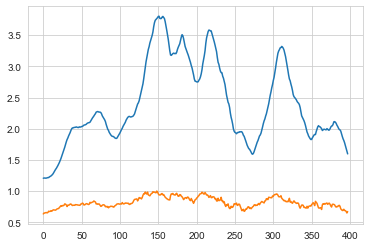

In [92]:
plt.plot(x, predictions)
plt.plot(x, y_test)

In [12]:
names=AAPL_df.columns.tolist()
names

['Date',
 'Close',
 'Volume',
 'Adj Close',
 '^DJI_Close',
 '^IXIC_Close',
 '^GSPC_Close',
 '^RLG_Close',
 '^NYA_Close',
 '^VIX_Close',
 'DX-Y.NYB_Close',
 'EURUSD=X_Close',
 'GBPUSD=X_Close',
 'GC=F_Close',
 'SI=F_Close',
 'CL=F_Close',
 'WM1NS',
 'WM2NS',
 'ICSA',
 'CCSA',
 'JTSJOL',
 'PAYEMS',
 'RSXFS',
 'TCU',
 'UMCSENT',
 'BUSINV',
 'INDPRO',
 'GACDFSA066MSFRBPHI',
 'GACDISA066MSFRBNY',
 'BACTSAMFRBDAL',
 'IR',
 'IQ',
 'PPIACO',
 'CPIAUCSL',
 'CPILFESL',
 'MICH',
 'CSCICP03USM665S',
 'Grow',
 'News_Score']

In [35]:

# example of a normalization
from numpy import asarray
from sklearn.preprocessing import MinMaxScaler
# define data
data = asarray([[100, 0.001],
 [8, 0.05],
 [50, 0.005],
 [88, 0.07],
 [4, 0.1]])
print(data)
# define min max scaler
scaler = MinMaxScaler()
# transform data
xg_feature = xg_feature[:-10]
scaled = scaler.fit_transform(xg_feature.reshape(-1, 1))
print(scaled)

[[1.0e+02 1.0e-03]
 [8.0e+00 5.0e-02]
 [5.0e+01 5.0e-03]
 [8.8e+01 7.0e-02]
 [4.0e+00 1.0e-01]]
[[0.00000000e+00]
 [2.79507098e-06]
 [2.34118170e-03]
 ...
 [3.54413473e-06]
 [1.87124905e-05]
 [0.00000000e+00]]


In [36]:
for item in scaled:
    print(item)

[0.]
[2.79507098e-06]
[0.00234118]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[6.37612722e-07]
[0.]
[0.]
[0.00197306]
[2.35317257e-05]
[0.]
[0.]
[5.3450227e-06]
[0.]
[7.33446225e-07]
[0.]
[0.]
[0.]
[0.]
[0.]
[3.27387379e-06]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.00010041]
[0.]
[0.]
[0.]
[0.]
[0.]
[3.96566448e-06]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[4.35702352e-06]
[0.]
[4.51000625e-06]
[2.41475408e-06]
[0.]
[0.]
[0.]
[0.]
[9.10448444e-06]
[0.]
[0.]
[2.67349944e-05]
[0.]
[0.]
[8.45845432e-06]
[0.]
[0.]
[0.]
[0.]
[1.0431282e-05]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[4.14394286e-06]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[1.62044965e-06]
[5.71054751e-06]
[0.]
[0.]
[0.]
[0.00154195]
[0.]
[1.31198856e-05]
[0.]
[0.00034143]
[1.97755035e-06]
[0.]
[0.]
[4.60824856e-06]
[3.17625477e-06]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.00085649]
[6.76633527e-06]
[0.]
[0.]
[0.]
[0.]
[1.09272915e-06]
[0.]
[0.]
[0.]
[0.]
[0.00357537]
[0.]
[0.]
[0.]


In [37]:
len(scaled)

1460